In [1]:
# import necessary modules and display matplotlib plots inline within the ipython notebook webpage

import pandas as pd, numpy as np, statsmodels.api as sm
import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
from scipy.stats import pearsonr, ttest_rel
%matplotlib inline

/Users/waddell/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
with open('pg_engine.txt') as f:
    pg_engine = f.readlines()
from sqlalchemy import create_engine
engine = create_engine(pg_engine[0])

In [3]:
%%time
import pandas as pd
df = pd.read_sql_query('select * from "rental_listings"',con=engine)

CPU times: user 43.5 s, sys: 9.94 s, total: 53.5 s
Wall time: 1min 47s


In [4]:
print(df.dtypes)
df.describe()

pid              object
date             object
region           object
neighborhood     object
rent            float64
bedrooms        float64
sqft            float64
rent_sqft       float64
longitude       float64
latitude        float64
county           object
fips_block       object
state            object
bathrooms       float64
dtype: object


rent      bedrooms          sqft     rent_sqft     longitude  \
count  1.160074e+07  1.160074e+07  1.160074e+07  1.160074e+07  1.160074e+07   
mean   4.519738e+04  1.803870e+00  1.062009e+03  6.004255e+01 -9.617954e+01   
std    9.100123e+06  9.553272e-01  9.518837e+03  1.471024e+04  1.686335e+01   
min    1.000000e+00  0.000000e+00  1.000000e+00  1.000001e-06 -1.793005e+02   
25%    8.710000e+02  1.000000e+00  7.360000e+02  9.329806e-01 -1.150722e+02   
50%    1.213000e+03  2.000000e+00  9.400000e+02  1.268182e+00 -9.426471e+01   
75%    1.735000e+03  2.000000e+00  1.170000e+03  1.879433e+00 -8.127608e+01   
max    2.147484e+09  1.270000e+02  8.388607e+06  1.651910e+07  1.000000e+03   

           latitude     bathrooms  
count  1.160074e+07  9.832297e+06  
mean   3.693122e+01  1.625104e+06  
std    5.201327e+00  3.610449e+09  
min   -8.539851e+01  0.000000e+00  
25%    3.343744e+01  1.000000e+00  
50%    3.719726e+01  1.000000e+00  
75%    4.011342e+01  2.000000e+00  
max    1.653830e+02  8.494864e+12

In [5]:
# convert the date column to yyyy-mm-dd date format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['week'] = df['date'].dt.week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df.head()

pid       date       region                          neighborhood  \
0  5919095844 2016-12-14        sfbay                            santa rosa   
1  6100090758 2017-04-22       dallas                           Garland, TX   
2  5919131593 2016-12-14        sfbay                     lake merrit/grand   
3  5922761883 2016-12-17   greensboro  26 Meadow crossing ct greensboro, NC   
4  5923368014 2016-12-17  minneapolis             Bloomington / Minneapolis   

     rent  bedrooms    sqft  rent_sqft   longitude   latitude    county  \
0  1200.0       1.0   400.0   3.000000 -122.705989  38.436196    Sonoma   
1  2410.0       3.0  1781.0   1.353172  -96.665400  32.952200    Dallas   
2  2300.0       1.0   750.0   3.066667 -122.266853  37.803128   Alameda   
3  1000.0       2.0  1036.0   0.965251  -79.883726  36.117492  Guilford   
4   925.0       1.0   750.0   1.233333  -93.266888  44.859276  Hennepin   

        fips_block state  bathrooms  week  month  year  
0  060971519001002    CA        NaN    50     12  2016  
1  481130190272027    TX        2.0    16      4  2017  
2  060014029001030    CA        NaN    50     12  2016  
3  370810160071002    NC        NaN    50     12  2016  
4  270530252012002    MN        NaN    50     12  2016

In [6]:
df['quarter'] = pd.cut(df['month'],4,labels=False)+1
df.head()

pid       date       region                          neighborhood  \
0  5919095844 2016-12-14        sfbay                            santa rosa   
1  6100090758 2017-04-22       dallas                           Garland, TX   
2  5919131593 2016-12-14        sfbay                     lake merrit/grand   
3  5922761883 2016-12-17   greensboro  26 Meadow crossing ct greensboro, NC   
4  5923368014 2016-12-17  minneapolis             Bloomington / Minneapolis   

     rent  bedrooms    sqft  rent_sqft   longitude   latitude    county  \
0  1200.0       1.0   400.0   3.000000 -122.705989  38.436196    Sonoma   
1  2410.0       3.0  1781.0   1.353172  -96.665400  32.952200    Dallas   
2  2300.0       1.0   750.0   3.066667 -122.266853  37.803128   Alameda   
3  1000.0       2.0  1036.0   0.965251  -79.883726  36.117492  Guilford   
4   925.0       1.0   750.0   1.233333  -93.266888  44.859276  Hennepin   

        fips_block state  bathrooms  week  month  year  quarter  
0  060971519001002    CA        NaN    50     12  2016        4  
1  481130190272027    TX        2.0    16      4  2017        2  
2  060014029001030    CA        NaN    50     12  2016        4  
3  370810160071002    NC        NaN    50     12  2016        4  
4  270530252012002    MN        NaN    50     12  2016        4

In [7]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

In [8]:
# define the font styles
family = 'Arial'
title_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

In [9]:
# load the 2014 census data set of MSAs
census = pd.read_csv('data/census_pop_income.csv', encoding='ISO-8859-1')
census['2014_median_income'] = census['2014_median_income'].str.replace(',','').astype(int)
census['2014_pop_est'] = census['2014_pop_est'].str.replace(',','').astype(int)
census = census.drop(labels='notes', axis=1, inplace=False)
census = census.set_index('region')
census.head()

2014_median_income  2014_pop_est  \
region                                         
newyork                  67066      20092883   
losangeles               60514      13262220   
chicago                  61598       9554598   
sfbay                    80600       8607423   
dallas                   59530       6954330   

                                          census_name  
region                                                 
newyork     New York-Newark-Jersey City, NY-NJ-PA MSA  
losangeles     Los Angeles-Long Beach-Anaheim, CA MSA  
chicago        Chicago-Naperville-Elgin, IL-IN-WI MSA  
sfbay          San Jose-San Francisco-Oakland, CA CSA  
dallas            Dallas-Fort Worth-Arlington, TX MSA

In [10]:
# these are the 15 most populous metros by population, defined by census bureau 2014 estimates
most_populous_regions = census['2014_pop_est'].sort_values(ascending=False, inplace=False)
print(most_populous_regions.head(15))

region
newyork         20092883
losangeles      13262220
chicago          9554598
sfbay            8607423
dallas           6954330
houston          6490180
philadelphia     6051170
washingtondc     6033737
miami            5929819
atlanta          5614323
boston           4732161
phoenix          4489109
inlandempire     4441890
detroit          4296611
seattle          3671478
Name: 2014_pop_est, dtype: int64


In [11]:
df['region'].value_counts()

NaN             787136
washingtondc    551568
losangeles      454082
seattle         449092
sfbay           427732
denver          332128
dallas          288293
phoenix         247287
lasvegas        246258
houston         241171
atlanta         240726
austin          233312
sandiego        232038
portland        231871
miami           223796
philadelphia    195752
chicago         178704
orangecounty    176240
tampa           141619
tucson          135295
orlando         133952
raleigh         128007
baltimore       124028
inlandempire    121970
jacksonville    118095
charlotte       117914
newyork         113682
columbus        113224
sacramento      109845
minneapolis     107522
                 ...  
lasalle            534
outerbanks         526
bemidji            519
potsdam            488
fortdodge          447
montana            428
meadville          413
klamath            408
mendocino          396
butte              391
masoncity          362
eastky             352
eastco     

In [12]:
dfnew = df.merge(census, left_on='region', right_index=True)
dfnew.head()

pid       date region        neighborhood    rent  bedrooms    sqft  \
0  5919095844 2016-12-14  sfbay          santa rosa  1200.0       1.0   400.0   
2  5919131593 2016-12-14  sfbay   lake merrit/grand  2300.0       1.0   750.0   
5  5919108651 2016-12-14  sfbay  SOMA / south beach  3600.0       1.0   650.0   
6  5919130479 2016-12-14  sfbay       san jose west  2650.0       2.0  1150.0   
7  5919130156 2016-12-14  sfbay       mountain view  2800.0       2.0   947.0   

   rent_sqft   longitude   latitude                   ...                    \
0   3.000000 -122.705989  38.436196                   ...                     
2   3.066667 -122.266853  37.803128                   ...                     
5   5.538462 -122.393572  37.786573                   ...                     
6   2.304348 -121.486592  38.042021                   ...                     
7   2.956705 -122.093800  37.396000                   ...                     

        fips_block state bathrooms  week  month  year  quarter  \
0  060971519001002    CA       NaN    50     12  2016        4   
2  060014029001030    CA       NaN    50     12  2016        4   
5  060750615002015    CA       NaN    50     12  2016        4   
6  060770040011140    CA       NaN    50     12  2016        4   
7  060855095002003    CA       NaN    50     12  2016        4   

   2014_median_income  2014_pop_est                             census_name  
0               80600       8607423  San Jose-San Francisco-Oakland, CA CSA  
2               80600       8607423  San Jose-San Francisco-Oakland, CA CSA  
5               80600       8607423  San Jose-San Francisco-Oakland, CA CSA  
6               80600       8607423  San Jose-San Francisco-Oakland, CA CSA  
7               80600       8607423  San Jose-San Francisco-Oakland, CA CSA  

[5 rows x 21 columns]

In [13]:
# function to save images consistently
save_dpi = [96, 300]
def save_fig(fig, title, tight=True):    
    if tight:
        fig.tight_layout()
    for dpi in save_dpi:
        save_folder = 'images/dpi_{}/'.format(dpi)
        fig.savefig(save_folder + title, dpi=dpi)

In [14]:
# create ticks and tick labels for the time series
listings_per_date = df['date'].value_counts()
listings_per_date = listings_per_date.sort_index()
listings_per_date = listings_per_date.reset_index()
xticks = listings_per_date.iloc[range(0, len(listings_per_date), 7)].index
xtick_labels = listings_per_date.loc[xticks, 'index']
xtick_labels = [str(x).split()[0] for x in xtick_labels]

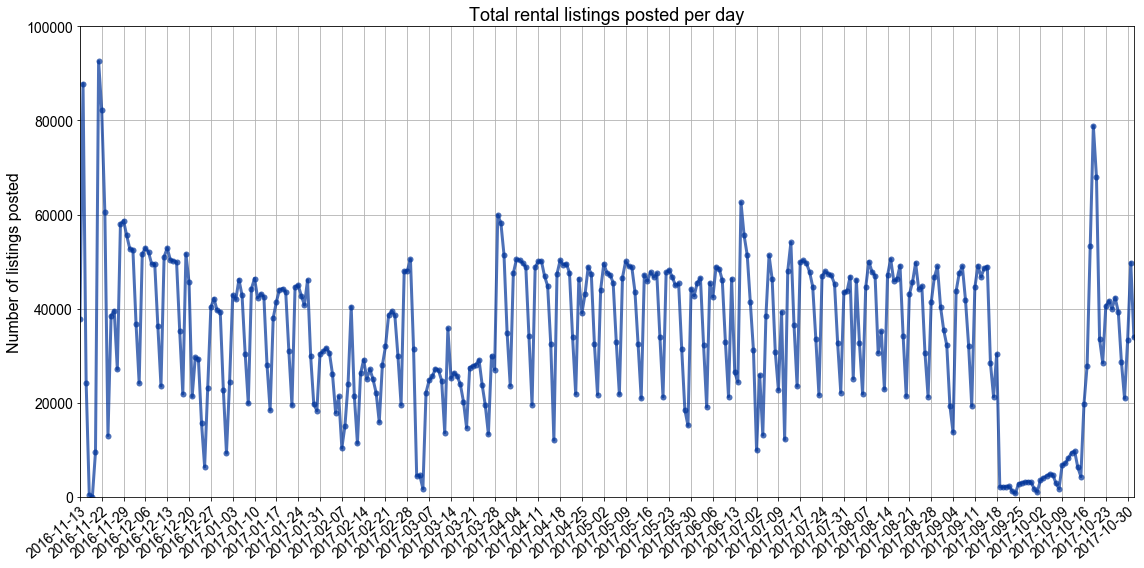

In [15]:
# plot the total number of listings (includes dupes/re-posts) posted on each day in the data set
ax = listings_per_date.plot(kind='line', figsize=[16, 8], ylim=[0,100000], linewidth=3, 
                            marker='o', markeredgewidth=0, alpha=0.7, color='#003399')
ax.grid(True)
ax.set_title('Total rental listings posted per day', fontproperties=title_font)
ax.set_ylabel('Number of listings posted', fontproperties=label_font)
ax.legend_.remove()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

save_fig(plt.gcf(), 'date_count_listings_posted.png')
plt.show()

In [35]:
#store = pd.HDFStore('data/rents.h5')
#store['rents'] = df
dfnew.to_hdf('data/rents.h5','rents',append=False)

/Users/waddell/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['pid', 'region', 'neighborhood', 'county', 'fips_block', 'state', 'census_name']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [36]:
store = pd.HDFStore('data/rents.h5')
store.close()

In [9]:
upper_percentile = 0.998
lower_percentile = 0.002

# how many rows would be within the upper and lower percentiles?
upper = int(len(df) * upper_percentile)
lower = int(len(df) * lower_percentile)

# get the rent/sqft values at the upper and lower percentiles
rent_sqft_sorted = df['rent_sqft'].sort_values(ascending=True, inplace=False)
upper_rent_sqft = rent_sqft_sorted.iloc[upper]
lower_rent_sqft = rent_sqft_sorted.iloc[lower]

# get the rent values at the upper and lower percentiles
rent_sorted = df['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = df['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent_sqft range:', [lower_rent_sqft, upper_rent_sqft])
print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent_sqft range: [0.012500000000000001, 9.9176470588235297]
valid rent range: [15.0, 9900.0]
valid sqft range: [200.0, 4440.0]


In [10]:
# create a boolean vector mask to filter out any rows with rent_sqft outside of the reasonable values
rent_sqft_mask = (df['rent_sqft'] > lower_rent_sqft) & (df['rent_sqft'] < upper_rent_sqft) & (df['bedrooms'] < 6)

# create boolean vector masks to filter out any rows with rent or sqft outside of the reasonable values
rent_mask = (df['rent'] > lower_rent) & (df['rent'] < upper_rent)
sqft_mask = (df['sqft'] > lower_sqft) & (df['sqft'] < upper_sqft)

# filter the thorough listings according to these masks
filtered_listings = pd.DataFrame(df[rent_sqft_mask & rent_mask & sqft_mask])
len(filtered_listings)

11495502

In [11]:
filtered_listings.describe()

rent      bedrooms          sqft     rent_sqft     longitude  \
count  1.149550e+07  1.149550e+07  1.149550e+07  1.149550e+07  1.149550e+07   
mean   1.426107e+03  1.794653e+00  1.008300e+03  1.522542e+00 -9.617082e+01   
std    8.337743e+02  9.307071e-01  4.237273e+02  8.640249e-01  1.685632e+01   
min    1.600000e+01  0.000000e+00  2.010000e+02  1.264299e-02 -1.793005e+02   
25%    8.750000e+02  1.000000e+00  7.370000e+02  9.349655e-01 -1.150671e+02   
50%    1.212000e+03  2.000000e+00  9.380000e+02  1.267943e+00 -9.422450e+01   
75%    1.725000e+03  2.000000e+00  1.165000e+03  1.872727e+00 -8.128198e+01   
max    9.899000e+03  5.000000e+00  4.439000e+03  9.917355e+00  1.000000e+03   

           latitude     bathrooms          week         month          year  \
count  1.149550e+07  9.747614e+06  1.149550e+07  1.149550e+07  1.149550e+07   
mean   3.693435e+01  1.639222e+06  2.597907e+01  6.393130e+00  2.016837e+03   
std    5.200395e+00  3.626098e+09  1.499707e+01  3.433150e+00  3.689374e-01   
min   -8.539851e+01  0.000000e+00  1.000000e+00  1.000000e+00  2.016000e+03   
25%    3.344038e+01  1.000000e+00  1.400000e+01  4.000000e+00  2.017000e+03   
50%    3.720868e+01  1.000000e+00  2.600000e+01  6.000000e+00  2.017000e+03   
75%    4.011189e+01  2.000000e+00  3.700000e+01  9.000000e+00  2.017000e+03   
max    1.653830e+02  8.494864e+12  5.200000e+01  1.200000e+01  2.017000e+03   

            quarter  
count  1.149550e+07  
mean   2.485146e+00  
std    1.082371e+00  
min    1.000000e+00  
25%    2.000000e+00  
50%    2.000000e+00  
75%    3.000000e+00  
max    4.000000e+00

In [12]:
filtered_listings.columns

Index(['pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft',
       'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state',
       'bathrooms', 'week', 'month', 'year', 'quarter'],
      dtype='object')

In [17]:
import geojson

def data2geojson(df):
    features = []
    df.apply(lambda X: features.append( 
            geojson.Feature(geometry=geojson.Point((X["longitude"], 
                                                    X["latitude"])), 
                properties=dict(pid=X["pid"], 
                                rent=X["rent"],
                                bedrooms=X["bedrooms"],
                                sqft=X["sqft"],
                                rent_sqft=X["rent_sqft"],
                                month=X["month"],
                                quarter=X["quarter"],
                                year=X["year"],
                                region=X["region"],
                                state=X["state"],
                                fips_block=X["fips_block"]))
                                    )
            , axis=1)
    with open('filtered_listings.geojson', 'w') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True)

In [19]:
%%time
data2geojson(filtered_listings)

CPU times: user 32min 4s, sys: 40.3 s, total: 32min 44s
Wall time: 1h 38min 14s


In [18]:
%%time
filtered_listings.to_csv('filtered_listings.csv')

CPU times: user 2min 15s, sys: 3.92 s, total: 2min 19s
Wall time: 2min 20s


In [21]:
sfbay = filtered_listings[filtered_listings['region']=='sfbay']
sfbay.describe()

rent       bedrooms           sqft      rent_sqft  \
count  422639.000000  422639.000000  422639.000000  422639.000000   
mean     2938.168948       1.747775    1003.233679       3.172509   
std      1123.898425       0.977841     457.578261       1.091982   
min        20.000000       0.000000     202.000000       0.020909   
25%      2207.000000       1.000000     711.000000       2.493750   
50%      2700.000000       2.000000     910.000000       3.000000   
75%      3400.000000       2.000000    1152.000000       3.676923   
max      9990.000000       8.000000    4434.000000       9.960159   

           longitude       latitude      bathrooms           week  \
count  422639.000000  422639.000000  355818.000000  422639.000000   
mean     -122.129983      37.634357       1.485622      25.630666   
std         0.822391       0.348061       0.615113      13.506599   
min      -174.418945      19.528063       0.000000       1.000000   
25%      -122.322500      37.376501       1.000000      15.000000   
50%      -122.074073      37.630668       1.000000      24.000000   
75%      -121.960486      37.800585       2.000000      34.000000   
max         2.496064      64.953325       7.000000      52.000000   

               month           year  
count  422639.000000  422639.000000  
mean        6.335187    2016.844631  
std         3.121261       0.362257  
min         1.000000    2016.000000  
25%         4.000000    2017.000000  
50%         6.000000    2017.000000  
75%         8.000000    2017.000000  
max        12.000000    2017.000000

In [33]:
sfbay.columns

Index(['pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft',
       'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state',
       'bathrooms', 'week', 'month', 'year'],
      dtype='object')

In [34]:
sfbay.to_csv('data/sfbay_listings_09_20_2017.csv')

In [35]:
sfbay_sept = sfbay[sfbay['month']==9]

In [36]:
sfbay_sept.describe()

rent      bedrooms          sqft     rent_sqft     longitude  \
count  30301.000000  30301.000000  30301.000000  30301.000000  30301.000000   
mean    2973.456718      1.772516   1015.012145      3.193192   -122.113992   
std     1095.293928      0.982335    475.511780      1.085101      1.170640   
min       21.000000      0.000000    203.000000      0.033600   -157.698500   
25%     2295.000000      1.000000    715.000000      2.511990   -122.305942   
50%     2750.000000      2.000000    920.000000      3.013959   -122.070774   
75%     3400.000000      2.000000   1155.000000      3.687500   -121.960317   
max     9950.000000      8.000000   4347.000000      9.775510      2.496064   

           latitude     bathrooms          week    month     year  
count  30301.000000  29681.000000  30301.000000  30301.0  30301.0  
mean      37.632033      1.497827     36.344543      9.0   2017.0  
std        0.358703      0.622051      0.753101      0.0      0.0  
min       21.298700      0.000000     35.000000      9.0   2017.0  
25%       37.375874      1.000000     36.000000      9.0   2017.0  
50%       37.618999      1.000000     36.000000      9.0   2017.0  
75%       37.800443      2.000000     37.000000      9.0   2017.0  
max       48.975011      5.500000     38.000000      9.0   2017.0

In [37]:
sfbay_sept.to_csv('data/sfbay_sept.csv')

In [22]:
sfbay['rent_sqft'].quantile(.01)

1.0

In [23]:
sfbay['sqft'].quantile(.01)

355.0

In [24]:
# create a boolean vector mask to filter out any rows with rent_sqft and sqft in Bay Area under 1 percentile
sfbay_rent_sqft_mask = (sfbay['rent_sqft'] > sfbay['rent_sqft'].quantile(.01) )

# create boolean vector masks to filter out any rows with rent or sqft outside of the reasonable values
sfbay_sqft_mask = (sfbay['sqft'] > sfbay['sqft'].quantile(.01) )

# filter the thorough listings according to these masks
sfbay_filtered = pd.DataFrame(sfbay[sfbay_rent_sqft_mask & sfbay_sqft_mask])
len(sfbay_filtered)

414026

In [25]:
sfbay_filtered.describe()

rent       bedrooms           sqft      rent_sqft  \
count  414026.000000  414026.000000  414026.000000  414026.000000   
mean     2967.380730       1.749873    1000.990389       3.170984   
std      1113.066294       0.961082     439.302661       1.024050   
min       600.000000       0.000000     356.000000       1.000743   
25%      2250.000000       1.000000     714.000000       2.500000   
50%      2716.000000       2.000000     910.000000       3.000000   
75%      3420.000000       2.000000    1150.000000       3.666667   
max      9990.000000       8.000000    4434.000000       9.960159   

           longitude       latitude     bathrooms           week  \
count  414026.000000  414026.000000  349316.00000  414026.000000   
mean     -122.134264      37.633624       1.48380      25.625444   
std         0.731489       0.336244       0.60949      13.503724   
min      -174.418945      19.528063       0.00000       1.000000   
25%      -122.319836      37.376400       1.00000      15.000000   
50%      -122.071860      37.608700       1.00000      24.000000   
75%      -121.960486      37.800075       2.00000      34.000000   
max         2.496064      48.975011       7.00000      52.000000   

               month           year  
count  414026.000000  414026.000000  
mean        6.334093    2016.844742  
std         3.120788       0.362151  
min         1.000000    2016.000000  
25%         4.000000    2017.000000  
50%         6.000000    2017.000000  
75%         8.000000    2017.000000  
max        12.000000    2017.000000

In [26]:
geocoded = pd.read_csv('data/craigslist_data_wblockid.csv', dtype={'GEOID10': object}).rename(columns={'GEOID10':'fips_block'})

In [41]:
# convert the date column to yyyy-mm-dd date format
geocoded['date'] = pd.to_datetime(geocoded['date'], format='%Y-%m-%d')
geocoded['week'] = geocoded['date'].dt.week
geocoded['month'] = geocoded['date'].dt.month
geocoded['year'] = geocoded['date'].dt.year
geocoded.head()

index         pid       date        region     neighborhood    rent  \
0      0  4454264047 2014-05-11  santabarbara              NaN  3500.0   
1      1  4437398427 2014-05-11  santabarbara  6533 Trigo Road   850.0   
2      2  4437286111 2014-05-11  santabarbara         downtown  2795.0   
3      3  4465598705 2014-05-11  santabarbara    santa barbara  5000.0   
4      4  4465561098 2014-05-11  santabarbara           Lompoc  1330.0   

   bedrooms    sqft  rent_sqft  rent_sqft_cat   longitude   latitude  \
0       3.0  1200.0   2.916667              5 -119.726987  34.399757   
1       2.0   882.0   0.963719              2 -119.855845  34.411019   
2       3.0  1200.0   2.329167              5 -119.712193  34.413942   
3       3.0  2000.0   2.500000              5 -119.692343  34.431691   
4       2.0  1000.0   1.330000              4 -120.469315  34.703429   

                                                geom       fips_block  week  \
0  0101000020E61000007F677BF486EE5DC06DACC43C2B33...  060830013048000    19   
1  0101000020E61000007D5C1B2AC6F65DC06F8445459C34...  060830029242004    19   
2  0101000020E61000002BDCF29194ED5DC06D382C0DFC34...  060830012031000    19   
3  0101000020E610000054A703594FEC5DC0207D93A64137...  060830006002000    19   
4  0101000020E61000006C21C841091E5EC06C0723F6095A...  060830028084014    19   

   month  year  
0      5  2014  
1      5  2014  
2      5  2014  
3      5  2014  
4      5  2014

In [42]:
print(geocoded.columns)
geocoded.describe()

Index(['index', 'pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms',
       'sqft', 'rent_sqft', 'rent_sqft_cat', 'longitude', 'latitude', 'geom',
       'fips_block', 'week', 'month', 'year'],
      dtype='object')


index           pid          rent      bedrooms          sqft  \
count  1.367142e+06  1.367142e+06  1.367142e+06  1.301693e+06  1.367142e+06   
mean   7.330246e+05  4.502898e+09  1.340748e+03  2.047311e+00  1.074148e+03   
std    4.206196e+05  3.252243e+07  8.156975e+02  9.272406e-01  5.103953e+02   
min    0.000000e+00  4.417508e+09  1.900000e+02  1.000000e+00  2.210000e+02   
25%    3.685862e+05  4.477738e+09  7.990000e+02  1.000000e+00  7.500000e+02   
50%    7.363475e+05  4.496396e+09  1.115000e+03  2.000000e+00  9.620000e+02   
75%    1.096559e+06  4.530615e+09  1.650000e+03  3.000000e+00  1.214000e+03   
max    1.456337e+06  4.574744e+09  1.028500e+04  8.000000e+00  5.192000e+03   

          rent_sqft  rent_sqft_cat     longitude      latitude          week  \
count  1.367142e+06   1.367142e+06  1.367142e+06  1.367142e+06  1.367142e+06   
mean   1.352719e+00   2.980504e+00 -1.012379e+02  3.708709e+01  2.294748e+01   
std    7.836169e-01   1.388046e+00  1.789768e+01  5.336504e+00  2.612611e+00   
min    1.004464e-01   1.000000e+00 -1.644361e+02  1.904303e+01  1.900000e+01   
25%    8.279793e-01   2.000000e+00 -1.179548e+02  3.354999e+01  2.100000e+01   
50%    1.096681e+00   3.000000e+00 -1.047681e+02  3.707657e+01  2.200000e+01   
75%    1.661392e+00   4.000000e+00 -8.338839e+01  4.033090e+01  2.500000e+01   
max    1.260504e+01   5.000000e+00 -6.702982e+01  6.591511e+01  2.900000e+01   

              month       year  
count  1.367142e+06  1367142.0  
mean   5.587902e+00     2014.0  
std    6.795093e-01        0.0  
min    5.000000e+00     2014.0  
25%    5.000000e+00     2014.0  
50%    5.000000e+00     2014.0  
75%    6.000000e+00     2014.0  
max    7.000000e+00     2014.0

In [43]:
geocoded6 = geocoded[geocoded['month']==6]
print(geocoded6['region'].value_counts().head(60))

sfbay           32331
seattle         28460
sandiego        22725
orangecounty    20413
losangeles      19327
sacramento      16313
inlandempire    16112
denver          15397
phoenix         15310
portland        13096
lasvegas        12284
washingtondc    11726
tucson          11131
dallas           9614
chicago          8623
houston          7198
miami            7184
fresno           5820
stlouis          5437
atlanta          5151
orlando          4837
newyork          4723
austin           4641
minneapolis      4521
tampa            4488
albuquerque      4473
boston           4440
cosprings        4250
kansascity       3666
reno             3504
raleigh          3450
spokane          3421
oklahomacity     3289
philadelphia     3246
charlotte        3184
jacksonville     3118
saltlakecity     3081
richmond         2944
ventura          2825
indianapolis     2631
norfolk          2556
columbus         2535
neworleans       2370
baltimore        2335
sanantonio       2320
milwaukee 

In [44]:
sfbay_geocoded = geocoded[geocoded['region']=='sfbay']
sfbay_geocoded.describe()

index           pid          rent      bedrooms          sqft  \
count  7.176700e+04  7.176700e+04  71767.000000  67161.000000  71767.000000   
mean   8.761931e+05  4.515081e+09   2529.436663      1.909218   1026.495311   
std    4.053274e+05  3.043084e+07   1104.966850      0.918099    503.167676   
min    6.064000e+03  4.419377e+09    285.000000      1.000000    221.000000   
25%    5.658775e+05  4.487801e+09   1835.000000      1.000000    722.000000   
50%    9.502680e+05  4.518829e+09   2325.000000      2.000000    903.000000   
75%    1.261562e+06  4.541766e+09   2954.000000      2.000000   1152.000000   
max    1.450750e+06  4.567896e+09  10250.000000      8.000000   5157.000000   

          rent_sqft  rent_sqft_cat     longitude      latitude          week  \
count  71767.000000   71767.000000  71767.000000  71767.000000  71767.000000   
mean       2.654153       4.733903   -122.113709     37.643169     23.836554   
std        0.948447       0.617483      0.415524      0.345550      2.651982   
min        0.140476       1.000000   -157.845039     21.290814     19.000000   
25%        2.054945       5.000000   -122.283936     37.378580     21.000000   
50%        2.578947       5.000000   -122.047200     37.586396     24.000000   
75%        3.111111       5.000000   -121.952200     37.844122     26.000000   
max       10.611888       5.000000    -70.690600     47.577915     28.000000   

              month     year  
count  71767.000000  71767.0  
mean       5.817521   2014.0  
std        0.718477      0.0  
min        5.000000   2014.0  
25%        5.000000   2014.0  
50%        6.000000   2014.0  
75%        6.000000   2014.0  
max        7.000000   2014.0

In [27]:
from pyproj import Proj, transform

## Datashader needs the location in web mercator coordiates

# WGS 84
inProj = Proj(init='epsg:4326')

# Web mercator 
outProj = Proj(init='epsg:3857')

geocoded['X'],geocoded['Y'] = transform(inProj,outProj,geocoded['longitude'].values,geocoded['latitude'].values)
geocoded[['X','Y']].describe()

X             Y
count  1.367142e+06  1.367142e+06
mean  -1.126975e+07  4.478751e+06
std    1.992361e+06  7.627512e+05
min   -1.830494e+07  2.160003e+06
25%   -1.313067e+07  3.968535e+06
50%   -1.166274e+07  4.449786e+06
75%   -9.282754e+06  4.914144e+06
max   -7.461725e+06  9.853650e+06

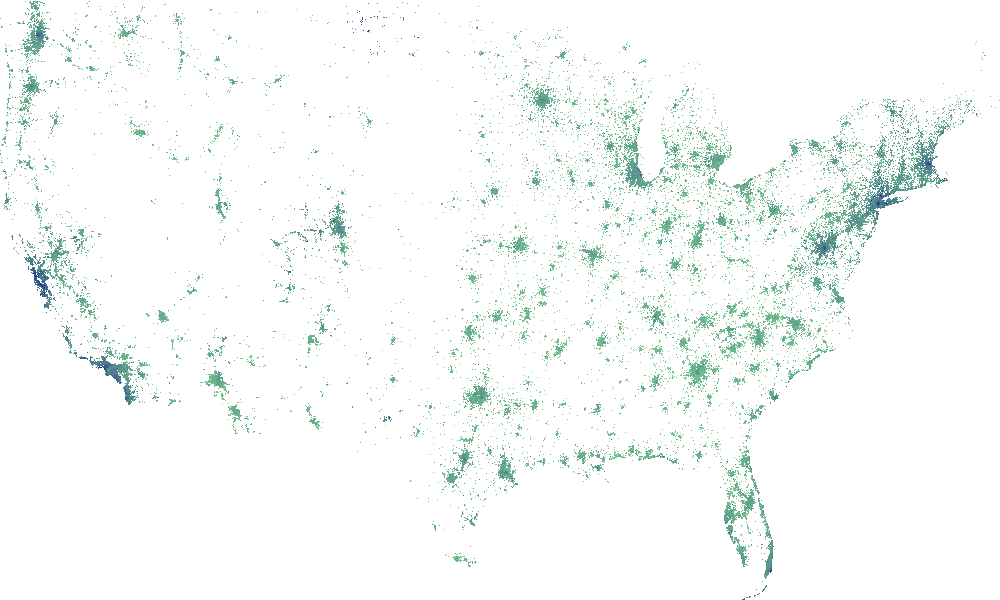

In [46]:
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd

US_XMin = -124.848974
US_XMax = -66.885444

US_YMin = 24.396308
US_YMax = 49.384358

geocoded = geocoded[(geocoded['longitude']>US_XMin) & (geocoded['longitude']<US_XMax)]
geocoded = geocoded[(geocoded['latitude']>US_YMin) & (geocoded['latitude']<US_YMax)]

cvs = ds.Canvas(plot_width=1000, plot_height=600)
agg = cvs.points(geocoded, 'longitude', 'latitude', ds.mean('rent_sqft'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
img

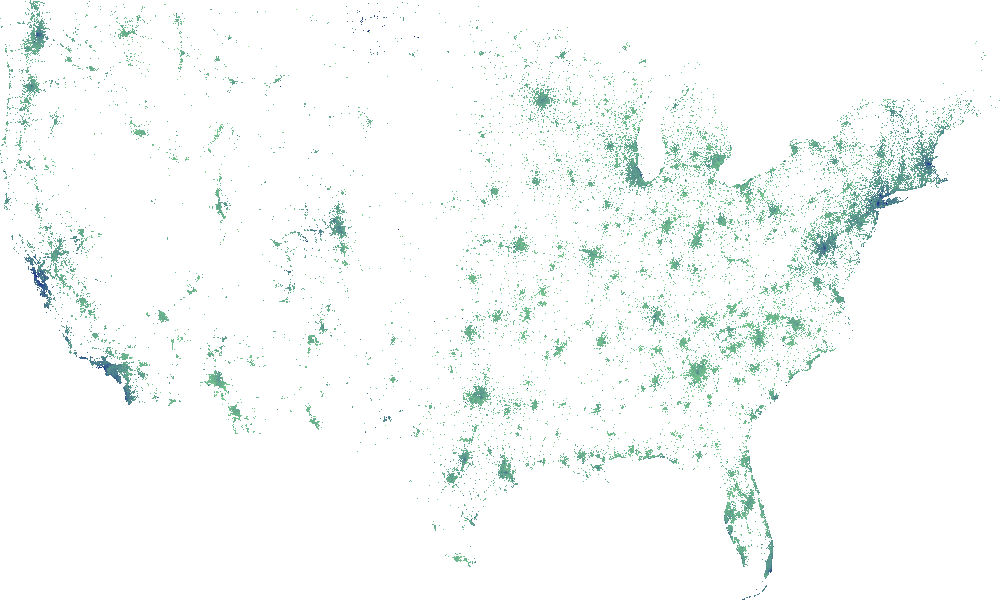

In [47]:
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd

US_XMin = -1.385944e+07
US_XMax = -7.461725e+06

US_YMin = 2.820464e+06
US_YMax = 6.274965e+06

geocoded = geocoded[(geocoded['X']>US_XMin) & (geocoded['X']<US_XMax)]
geocoded = geocoded[(geocoded['Y']>US_YMin) & (geocoded['Y']<US_YMax)]

cvs = ds.Canvas(plot_width=1000, plot_height=600)
agg = cvs.points(geocoded, 'longitude', 'latitude', ds.mean('rent_sqft'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
img

In [48]:
filtered_listings['X'],filtered_listings['Y'] = transform(inProj,outProj,filtered_listings['longitude'].values,filtered_listings['latitude'].values)

US_XMin = -1.385944e+07
US_XMax = -7.461725e+06

US_YMin = 2.820464e+06
US_YMax = 6.274965e+06

filtered_listings = filtered_listings[(filtered_listings['X']>US_XMin) & (filtered_listings['X']<US_XMax)]
filtered_listings = filtered_listings[(filtered_listings['Y']>US_YMin) & (filtered_listings['Y']<US_YMax)]

filtered_listings[['longitude','latitude','X','Y']].describe()

longitude      latitude             X             Y
count  4.111319e+06  4.111319e+06  4.111319e+06  4.111319e+06
mean  -9.597243e+01  3.688610e+01 -1.068360e+07  4.448094e+06
std    1.672478e+01  5.166008e+00  1.861794e+06  7.269734e+05
min   -1.244988e+02  2.454920e+01 -1.385914e+07  2.820474e+06
25%   -1.123103e+02  3.340745e+01 -1.250233e+07  3.949511e+06
50%   -9.422491e+01  3.685042e+01 -1.048907e+07  4.418278e+06
75%   -8.121407e+01  4.011118e+01 -9.040709e+06  4.882112e+06
max   -6.717486e+01  4.900032e+01 -7.477871e+06  6.274916e+06

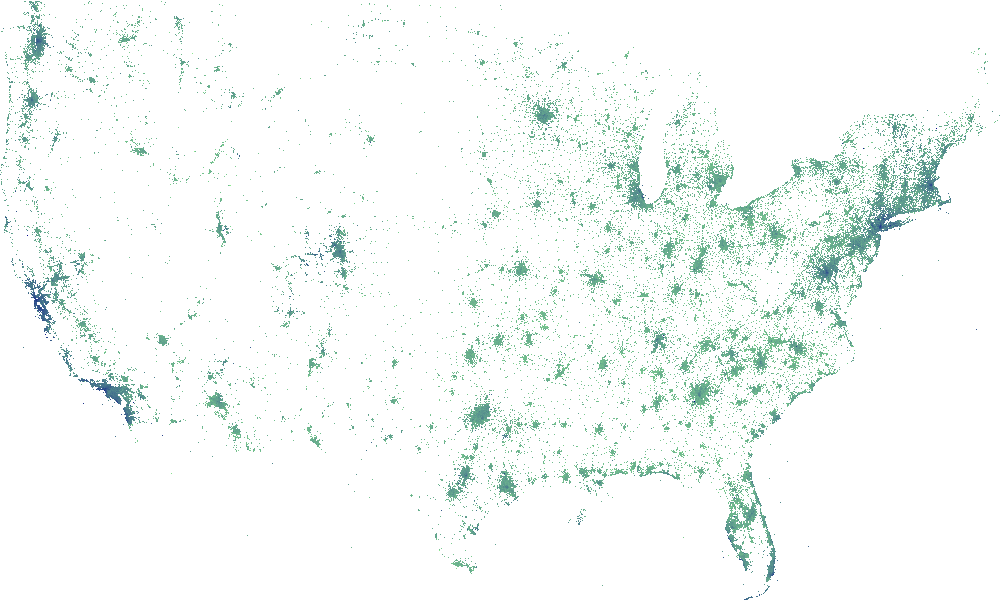

In [49]:
cvs = ds.Canvas(plot_width=1000, plot_height=600)
agg = cvs.points(filtered_listings, 'X', 'Y', ds.mean('rent_sqft'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
img

In [50]:
import datashader as ds 
import datashader.transfer_functions as tf
from datashader.colors import Greys9, Hot, colormap_select as cm 
def bg(img): return tf.set_background(img,"black")

In [51]:
#USA = ((-124.848974, -66.885444), (24.396308, 49.384358))
USA = ((-1.385944e+07, -7.461725e+06), (2.820464e+06, 6.274965e+06)) 
x_range,y_range = USA
 
plot_width = int(900)
plot_height = int(plot_width*7.0/12)

In [52]:
def create_image(x_range, y_range, w=plot_width, h=plot_height, spread=0):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'meterswest', 'metersnorth', ds.count_cat('race'))
    img = tf.colorize(agg, color_key, how='eq_hist')
    if spread: img = tf.spread(img,px=spread)
    return tf.set_background(img,"black")

In [57]:
from bokeh.tile_providers import STAMEN_TERRAIN
from bokeh.tile_providers import STAMEN_TONER
from bokeh.tile_providers import CARTODBPOSITRON_RETINA

from bokeh.embed import file_html
from bokeh.plotting import figure, output_notebook, output_file, show
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from bokeh.resources import CDN
from bokeh.io import save


from functools import partial

output_notebook()

Loading BokehJS ...

In [54]:
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
 
bp.output_notebook()
 
def base_plot(tools='pan,wheel_zoom,reset',webgl=False):
     p = bp.figure(tools=tools,
         plot_width=int(900), plot_height=int(500),
         x_range=x_range, y_range=y_range, outline_line_color=None,
         min_border=0, min_border_left=0, min_border_right=0,
         min_border_top=0, min_border_bottom=0, webgl=webgl)
 
     p.axis.visible = False
     p.xgrid.grid_line_color = None
     p.ygrid.grid_line_color = None
 
     return p
 
p = base_plot()
 
url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png" 
tile_renderer = p.add_tile(WMTSTileSource(url=url)) 
tile_renderer.alpha=1.0

Loading BokehJS ...

In [55]:
from datashader.bokeh_ext import InteractiveImage
background = 'white'

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=1000, plot_height=600)
    agg = cvs.points(filtered_listings, 'X', 'Y', ds.mean('rent_sqft'))
    img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
    return tf.dynspread(img,threshold=0.75, max_px=8)

p = base_plot()

#url="http://tile.stamen.com/toner-background/{Z}/{X}/{Y}.png"
url="http://tile.stamen.com/terrain/{Z}/{X}/{Y}.png"
#url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png"
tile_renderer = p.add_tile(WMTSTileSource(url=url))
tile_renderer.alpha=1.0 if background == "black" else 0.15

InteractiveImage(p, image_callback)

In [58]:
#US = x_range, y_range = ((df_slice.xWeb.min(),df_slice.xWeb.max()), (4898057.594904038,5565974.539663678))
USA = ((-1.385944e+07, -7.461725e+06), (2.820464e+06, 6.274965e+06)) 
x_range,y_range = USA

plot_width  = int(900)
plot_height = int(plot_width//1.4)


def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height, webgl=True,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):    
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(filtered_listings, 'X', 'Y', ds.mean('rent_sqft'))
    img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')

    #img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot()
p.add_tile(CARTODBPOSITRON_RETINA)

# this export step is not neccesary - it saves a PNG of the file
#export(create_image(*USA),"US_CL")
#html = save(p, "craigslist")


# this is where the magic happens
InteractiveImage(p, create_image)

In [ ]:
Html_file= open("craigslist.html","w")
Html_file.write(html)
Html_file.close()

In [28]:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
y, X = dmatrices('np.log(rent) ~ np.log(sqft) + bedrooms', data=sfbay_geocoded, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

NameError: name 'sfbay_geocoded' is not defined

In [ ]:
errors =  res.resid
errors.hist(bins=25)

In [ ]:
pred = res.fittedvalues
pred.hist(bins=25)

In [ ]:
plt.figure(1, figsize=(10,8), )
plt.scatter(res.fittedvalues, res.resid, s=.03, color='green')
plt.show();

In [29]:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
y, X = dmatrices('np.log(rent) ~ np.log(sqft) + bedrooms', data=sfbay_filtered, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(rent)   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                 1.275e+05
Date:                Wed, 20 Sep 2017   Prob (F-statistic):               0.00
Time:                        09:04:56   Log-Likelihood:                -37080.
No. Observations:              414026   AIC:                         7.417e+04
Df Residuals:                  414023   BIC:                         7.420e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.9886      0.012    326.711   

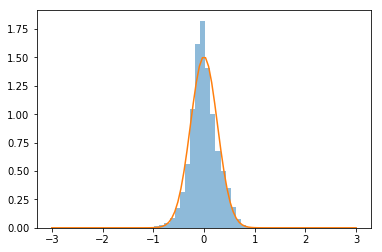

In [30]:
plt.hist(residuals, bins=25, normed=True, alpha=.5)
mu = residuals.mean()
variance = residuals.var()
sigma = residuals.std()
x = np.linspace(-3, 3, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma));

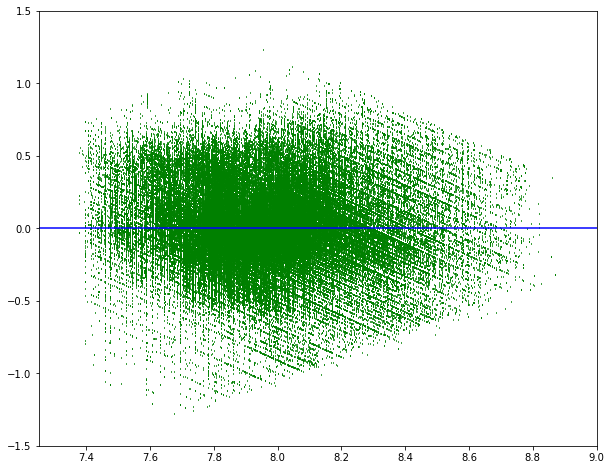

In [31]:
plt.figure(1, figsize=(10,8), )
plt.plot([7, 9], [0, 0], c='b')
plt.scatter(predicted, residuals, marker=0, s=2, c='g');
plt.axis([7.25, 9, -1.5, 1.5])
plt.show();

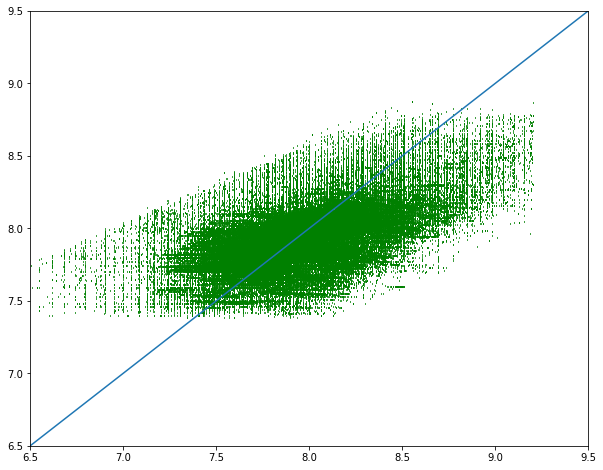

In [32]:
plt.figure(1, figsize=(10,8), )
plt.plot([6, 9.5], [6, 9.5])
plt.scatter(observed, predicted, marker=0, s=2, c='g')
plt.axis([6.5, 9.5, 6.5, 9.5])
plt.show();

In [ ]:
print(residuals.mean())
print(residuals.std())

In [ ]:
mod = sm.WLS(y, X, weights=1.)
res = mod.fit()
print(res.summary())

In [ ]:
from pymc3 import Model, NUTS, sample
from pymc3.glm import glm

with Model() as model_glm:
    glm('np.log(rent) ~ np.log(sqft) + bedrooms + bathrooms', sfbay_filtered)
    trace = sample(5000)

In [ ]:
from pymc3 import traceplot
%matplotlib inline
traceplot(trace);

In [ ]:
from scipy import optimize
from pymc3 import find_MAP
with model_glm:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # draw 2000 posterior samples
    trace = sample(5000, start=start)

In [ ]:
traceplot(trace);

In [ ]:
import matplotlib.pyplot as plt
import theano
import pymc3 as pm

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(np.log(sfbay['sqft']), np.log(sfbay['rent']), 'o', markersize=.5, color='blue', label='sampled data')
#ax.plot(x, true_regression_line, label='true regression line', lw=2.)
#pm.glm.plot_posterior_predictive(trace, samples=100,
#                                 label='posterior predictive regression lines')
plt.legend(loc=0);

In [ ]:
#Write out selected counties for student use
sanfrancisco = geocoded[geocoded['fips_block'].str.startswith('06075')]
alameda = geocoded[geocoded['fips_block'].str.startswith('06001')]
denver = geocoded[geocoded['fips_block'].str.startswith('08031')]
washingtondc = geocoded[geocoded['fips_block'].str.startswith('11001')]
king = geocoded[geocoded['fips_block'].str.startswith('53033')]
cook = geocoded[geocoded['fips_block'].str.startswith('17031')]
neworleans = geocoded[geocoded['fips_block'].str.startswith('22071')]
suffolk = geocoded[geocoded['fips_block'].str.startswith('25025')]
manhattan = geocoded[geocoded['fips_block'].str.startswith('36061')]
kings = geocoded[geocoded['fips_block'].str.startswith('36047')]
staten = geocoded[geocoded['fips_block'].str.startswith('36085')]
bronx = geocoded[geocoded['fips_block'].str.startswith('36005')]
queens = geocoded[geocoded['fips_block'].str.startswith('36081')]
wayne = geocoded[geocoded['fips_block'].str.startswith('42127')]
multnomah = geocoded[geocoded['fips_block'].str.startswith('41051')]
austin = geocoded[geocoded['fips_block'].str.startswith('48015')]

sanfrancisco.to_csv('sanfrancisco.csv')
alameda.to_csv('alameda.csv')
denver.to_csv('denver.csv')
washingtondc.to_csv('washingtondc.csv')
king.to_csv('king.csv')
cook.to_csv('cook.csv')
neworleans.to_csv('neworleans.csv')
suffolk.to_csv('suffolk.csv')
manhattan.to_csv('manhattan.csv')
kings.to_csv('kings.csv')
staten.to_csv('staten.csv')
bronx.to_csv('bronx.csv')
queens.to_csv('queens.csv')
wayne.to_csv('wayne.csv')
multnomah.to_csv('multnomah.csv')
austin.to_csv('austin.csv')

In [ ]:
austin = geocoded[geocoded['fips_block'].str.startswith('48453')]
austin.describe()
austin.to_csv('austin.csv')

In [ ]:
middlesex = geocoded[geocoded['fips_block'].str.startswith('25017')]
middlesex.describe()
#middlesex.to_csv('middlesex.csv')